In [1]:
!pip install timm

In [2]:
import os
from tqdm import tqdm
import pickle
import argparse
import time
import torch
import yaml
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from IPython.display import display

from utils import set_seed, load_model, save, get_model, update_optimizer, get_data
from epoch import train_epoch, val_epoch, test_epoch
from cli import add_all_parsers
import greenstand_utils as gu  # GREENSTAND


def get_args(hyperparameter_config_file='hyperparameters.yaml'):
    with open(hyperparameter_config_file) as file:
        contents = yaml.safe_load(file)
    new_args = []
    for item in contents:
        new_args.append('--' + item)
        new_args.append(str(contents[item]))
    return new_args


def train(args):
    set_seed(args, use_gpu=torch.cuda.is_available())
    
    # Get Data  # GREENSTAND
    g_args = vars(args) # GREENSTAND
    g_args['prefixes'] = g_args['prefixes'].split(',') # GREENSTAND
    train_loader, val_loader, test_loader, dataset_attributes = gu.sync_split_get_dataloaders(vars(args))  # GREENSTAND
    print(f"Dataset Attributes: {dataset_attributes}") # GREENSTANDS

    model = gu.load_preloaded_model(args, dataset_attributes)  # GREENSTAND - Get pretrained model if specified 
    criteria = CrossEntropyLoss() 

    if args.use_gpu:
        torch.cuda.set_device(0)
        model.cuda()
        criteria.cuda()

    optimizer = SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.mu, nesterov=True)

    # Containers for storing metrics over epochs
    loss_train, acc_train, topk_acc_train = [], [], []
    loss_val, acc_val, topk_acc_val, avgk_acc_val, class_acc_val = [], [], [], [], []

    save_name = args.save_name_xp.strip()
    save_dir = os.path.join(os.getcwd(), 'results', save_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print('args.k : ', args.k)

    lmbda_best_acc = None
    best_val_acc = float('-inf')

    for epoch in tqdm(range(args.n_epochs), desc='epoch', position=0):
        t = time.time()
        optimizer = update_optimizer(optimizer, lr_schedule=dataset_attributes['lr_schedule'], epoch=epoch)

        loss_epoch_train, acc_epoch_train, topk_acc_epoch_train = train_epoch(model, optimizer, train_loader,
                                                                              criteria, loss_train, acc_train,
                                                                              topk_acc_train, args.k,
                                                                              dataset_attributes['n_train'],
                                                                              args.use_gpu)

        loss_epoch_val, acc_epoch_val, topk_acc_epoch_val, \
        avgk_acc_epoch_val, lmbda_val = val_epoch(model, val_loader, criteria,
                                                  loss_val, acc_val, topk_acc_val, avgk_acc_val,
                                                  class_acc_val, args.k, dataset_attributes, args.use_gpu)

        # save model at every epoch
        save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights.tar'))

        # save model with best val accuracy
        if acc_epoch_val > best_val_acc:
            best_val_acc = acc_epoch_val
            lmbda_best_acc = lmbda_val
            save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights_best_acc.tar'))

        print()
        print(f'epoch {epoch} took {time.time()-t:.2f}')
        print(f'loss_train : {loss_epoch_train}')
        print(f'loss_val : {loss_epoch_val}')
        print(f'acc_train : {acc_epoch_train} / topk_acc_train : {topk_acc_epoch_train}')
        print(f'acc_val : {acc_epoch_val} / topk_acc_val : {topk_acc_epoch_val} / '
              f'avgk_acc_val : {avgk_acc_epoch_val}')

    # load weights corresponding to best val accuracy and evaluate on test
    load_model(model, os.path.join(save_dir, save_name + '_weights_best_acc.tar'), args.use_gpu)
    loss_test_ba, acc_test_ba, topk_acc_test_ba, \
    avgk_acc_test_ba, class_acc_test, confuse = test_epoch(model, test_loader, criteria, args.k,
                                                  lmbda_best_acc, args.use_gpu,
                                                  dataset_attributes)
    
    print("Average test accuracy: {}".format(avgk_acc_test_ba))
    print("Average class accuracies: {}".format(class_acc_test))
    display(confuse)

    # Save the results as a dictionary and save it as a pickle file in desired location

    results = {'loss_train': loss_train, 'acc_train': acc_train, 'topk_acc_train': topk_acc_train,
               'loss_val': loss_val, 'acc_val': acc_val, 'topk_acc_val': topk_acc_val, 'class_acc_val': class_acc_val,
               'avgk_acc_val': avgk_acc_val,
               'test_results': {'loss': loss_test_ba,
                                'accuracy': acc_test_ba,
                                'topk_accuracy': topk_acc_test_ba,
                                'avgk_accuracy': avgk_acc_test_ba,
                                'class_acc_dict': class_acc_test},
               'params': args.__dict__}

    with open(os.path.join(save_dir, save_name + '.pkl'), 'wb') as f:
        pickle.dump(results, f)
        

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Use CUDA: True
Seed:	 1
Checking to make sure all local files are present...
Checking missing local files based on bucket: treetracker-training-images at prefix haiti/...
No missing items locally.
Checking missing local files based on bucket: treetracker-training-images at prefix herbarium/...
No missing items locally.
Creating metadata file with pre-determined train, val, test splits...
Loading datasets...
Will not include class PERSAMER due to not having enough data for train/val/test split...
Will not include class CUPRLUSI due to not having enough data for train/val/test split...
Writing metadata.json...
Creating data loaders...
Loading datasets...


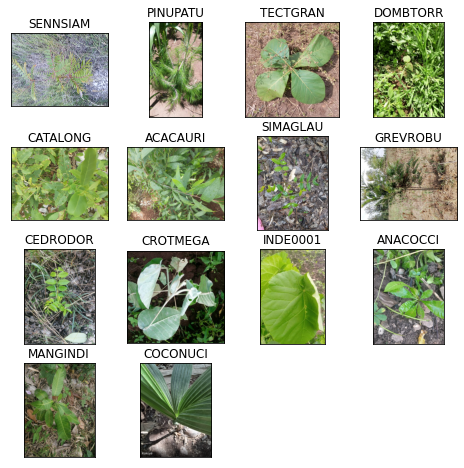

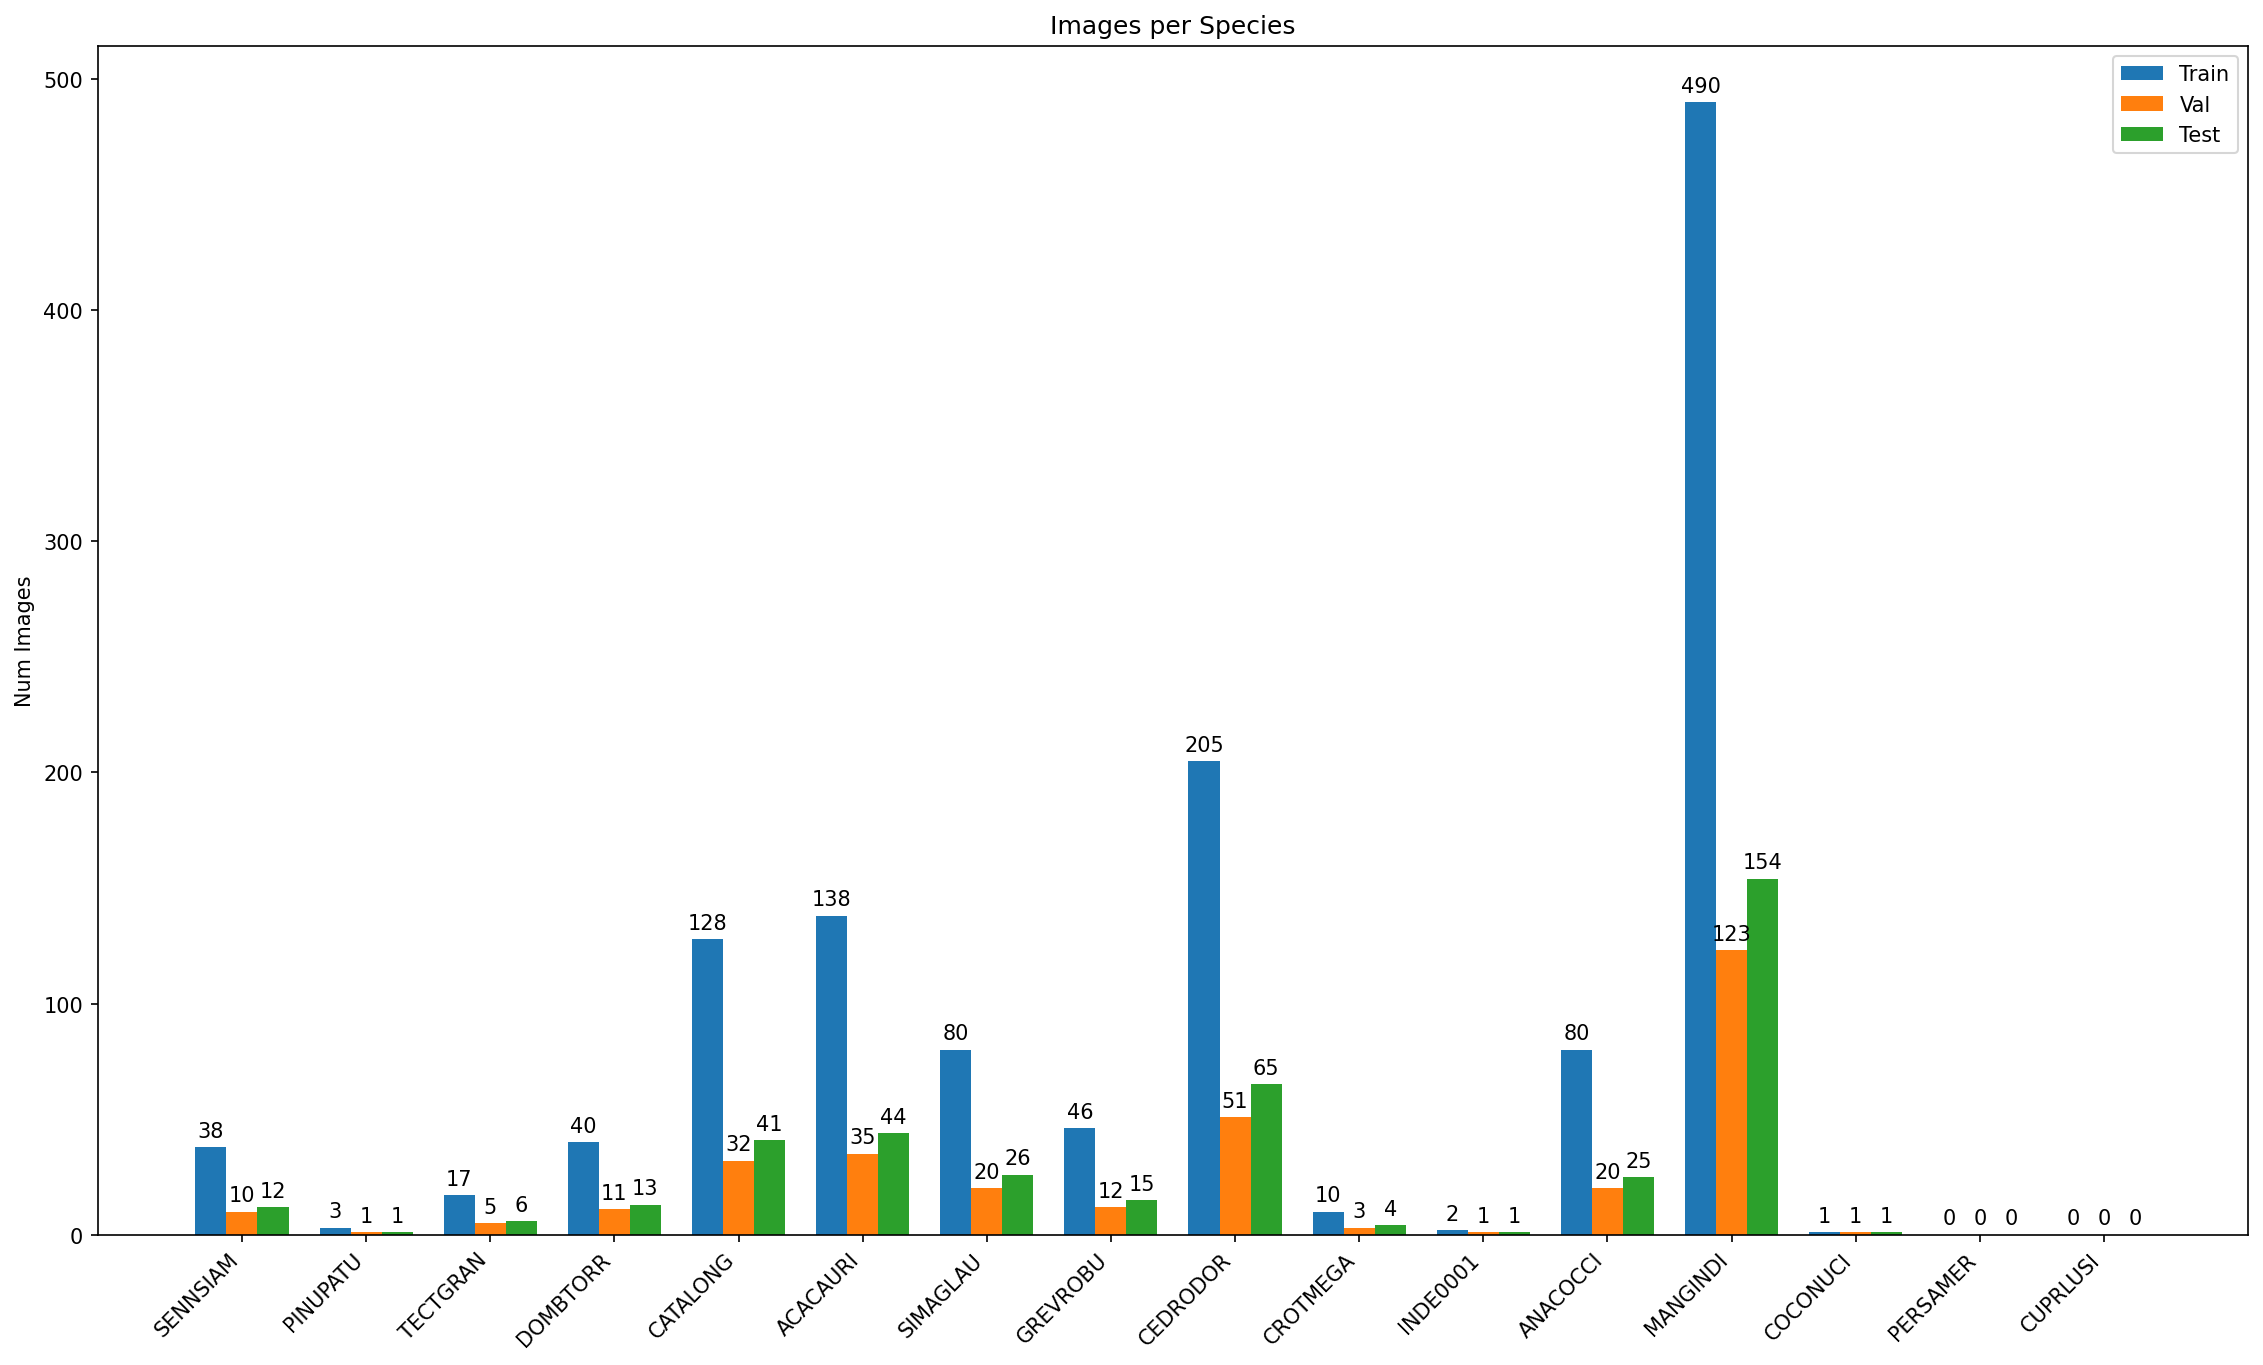

Dataset Attributes: {'n_train': 1278, 'n_val': 325, 'n_test': 408, 'n_classes': 14, 'lr_schedule': [40, 50, 60], 'class2num_instances': {'train': {0: 38, 1: 3, 2: 17, 3: 40, 4: 128, 5: 138, 6: 80, 7: 46, 8: 205, 9: 10, 10: 2, 11: 80, 12: 490, 13: 1}, 'val': {0: 10, 1: 1, 2: 5, 3: 11, 4: 32, 5: 35, 6: 20, 7: 12, 8: 51, 9: 3, 10: 1, 11: 20, 12: 123, 13: 1}, 'test': {0: 12, 1: 1, 2: 6, 3: 13, 4: 41, 5: 44, 6: 26, 7: 15, 8: 65, 9: 4, 10: 1, 11: 25, 12: 154, 13: 1}}, 'class_to_idx': {'SENNSIAM': 0, 'PINUPATU': 1, 'TECTGRAN': 2, 'DOMBTORR': 3, 'CATALONG': 4, 'ACACAURI': 5, 'SIMAGLAU': 6, 'GREVROBU': 7, 'CEDRODOR': 8, 'CROTMEGA': 9, 'INDE0001': 10, 'ANACOCCI': 11, 'MANGINDI': 12, 'COCONUCI': 13}, 'invalid_classes': ['PERSAMER', 'CUPRLUSI'], 'total_instances_per_class': {'SENNSIAM': 60, 'PINUPATU': 5, 'TECTGRAN': 28, 'DOMBTORR': 64, 'CATALONG': 201, 'SIMAGLAU': 126, 'GREVROBU': 73, 'MANGINDI': 767, 'CEDRODOR': 321, 'CROTMEGA': 17, 'INDE0001': 4, 'ACACAURI': 217, 'ANACOCCI': 125, 'COCONUCI': 3}

In [3]:
"""To run: python main.py --lr=0.05 --n_epochs=80 --k 1 3 5 10 --model=resnet50 --root=path_to_data --save_name_xp=xp1"""

"""
Provide your arguments here in this format:
[
 argname1, argvalue1,
 argname2, argvalue2
]
"""
print(f"Use CUDA: {torch.cuda.is_available()}")
arg_list = get_args()
parser = argparse.ArgumentParser()
add_all_parsers(parser)
args = parser.parse_args(args=arg_list)
train(args)